Script Name: SZ_aed  
Author: Fatemeh Delavari  
Version: 2.0 (10/14/2024)  
Description: Performs graph analysis on an epileptic EEG recording

In [1]:
import mne
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

In [62]:
# Specify the path to your EDF file
file_name = 'aaaaaaed_s001_t000.edf'
folder_path = 'C:/Users/Atena/Documents/seizure_files/aed'
file_path = os.path.join(folder_path, file_name)

# Read the EDF file
raw = mne.io.read_raw_edf(file_path, preload=True)

# Get basic information
print(raw.info)
print(raw.ch_names)

sampfreq = int(raw.info['sfreq'])

# Extract signal data
data, times = raw[:]

print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

Extracting EDF parameters from C:\Users\Atena\Documents\seizure_files\aed\aaaaaaed_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 29999  =      0.000 ...   119.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-LE, EEG FP2-LE, EEG F3-LE, EEG F4-LE, EEG C3-LE, EEG ...
 chs: 33 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-01-01 00:00:00 UTC
 nchan: 33
 projs: []
 sfreq: 250.0 Hz
 subject_info: 3 items (dict)
>
['EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE', 'EEG C4-LE', 'EEG A1-LE', 'EEG A2-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE', 'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE', 'EEG OZ-LE', 'EEG PG1-LE', 'EEG PG2-LE', 'EEG EKG-LE', 'EEG SP2-LE', 'EEG SP1-LE', 'EEG RLC-LE', 'EEG LUC-LE', 'EEG 30-LE', 'EEG T1-LE', 'EEG T2-LE', 'PHOTIC PH']
Data shape: (33, 30000)
T

In [63]:
# In the first ~ 15 sec the electrodes are disconnected
start_time = 15  # in seconds
end_time = raw.times[-1]  # until the end of the recording

# Crop the data to remove the first 50 seconds
raw.crop(tmin=start_time, tmax=end_time)

# Extract signal data
data, times = raw[:]

print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

Data shape: (33, 26250)
Times shape: (26250,)


In [64]:
simplified_names = [
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',
    'T5', 'T6', 'FZ', 'CZ', 'PZ'
]

In [65]:
# Define the channels you want to select
selected_channels = selected_channels = ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F7-LE', 'EEG F3-LE', 'EEG FZ-LE', 'EEG F4-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG C3-LE', 'EEG CZ-LE', 'EEG C4-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG P3-LE', 'EEG PZ-LE', 'EEG P4-LE', 'EEG T6-LE', 'EEG O1-LE', 'EEG O2-LE']

raw_selected = raw.copy()
# Select the specified channels
raw_selected = raw_selected.pick_channels(selected_channels)

# Extract signal data for the selected channels
data, times = raw_selected[:]

print(f"Selected channels: {raw_selected.ch_names}")
print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected channels: ['EEG FP1-LE', 'EEG FP2-LE', 'EEG F7-LE', 'EEG F3-LE', 'EEG FZ-LE', 'EEG F4-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG C3-LE', 'EEG CZ-LE', 'EEG C4-LE', 'EEG T4-LE', 'EEG T5-LE', 'EEG P3-LE', 'EEG PZ-LE', 'EEG P4-LE', 'EEG T6-LE', 'EEG O1-LE', 'EEG O2-LE']
Data shape: (19, 26250)
Times shape: (26250,)


In [66]:
preprocEEG = raw_selected.copy()

# Define the Butterworth filter parameters with filtfilt applied
iir_params = dict(order=6, ftype='butter', output='sos')

# Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
preprocEEG.filter(l_freq=1.0, h_freq=40, method='iir', iir_params=iir_params, phase='zero')

# Notch filter to remove power line noise (assuming 60 Hz)
preprocEEG.notch_filter(freqs=60.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.0s finished


Measurement date,"January 01, 2003 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaaaed
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


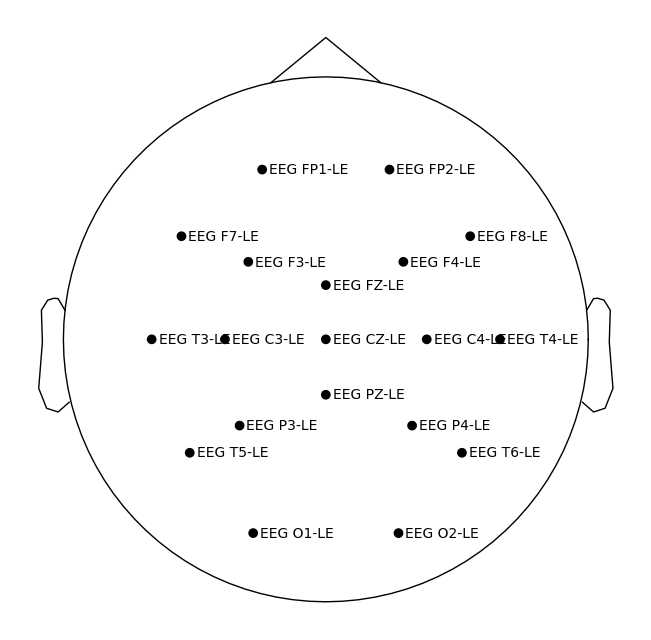

In [67]:
# Define positions (in meters) for the channels
pos = {'FP1': (-0.03, 0.08, 0.05),
'FP2': (0.03, 0.08, 0.05),
'F3': (-0.04, 0.04, 0.06),
'F4': (0.04, 0.04, 0.06),
'C3': (-0.05, 0.00, 0.04),
'C4': (0.05, 0.00, 0.04),
'P3': (-0.04, -0.04, 0.03),
'P4': (0.04, -0.04, 0.03),
'O1': (-0.03, -0.08, 0.02),
'O2': (0.03, -0.08, 0.02),
'F7': (-0.07, 0.05, 0.06),
'F8': (0.07, 0.05, 0.06),
'T3': (-0.08, 0.00, 0.04),
'T4': (0.08, 0.00, 0.04),
'T5': (-0.06, -0.05, 0.03),
'T6': (0.06, -0.05, 0.03),
'FZ': (0.00, 0.03, 0.07),
'CZ': (0.00, 0.00, 0.06),
'PZ': (0.00, -0.03, 0.05)}

# Convert positions to a format compatible with MNE
montage_positions = {ch_name: np.array(pos[ch_name.replace('EEG ', '').replace('-LE', '')])
                     for ch_name in selected_channels}


# Create a custom montage
montage = mne.channels.make_dig_montage(ch_pos=montage_positions, coord_frame='head')

# Apply the montage to the raw data
preprocEEG.set_montage(montage)

plt.close('all')
# Plot to verify that electrode locations are now added
preprocEEG.plot_sensors(show_names=True)

plt.close('all')

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 19 components
Fitting ICA took 0.2s.


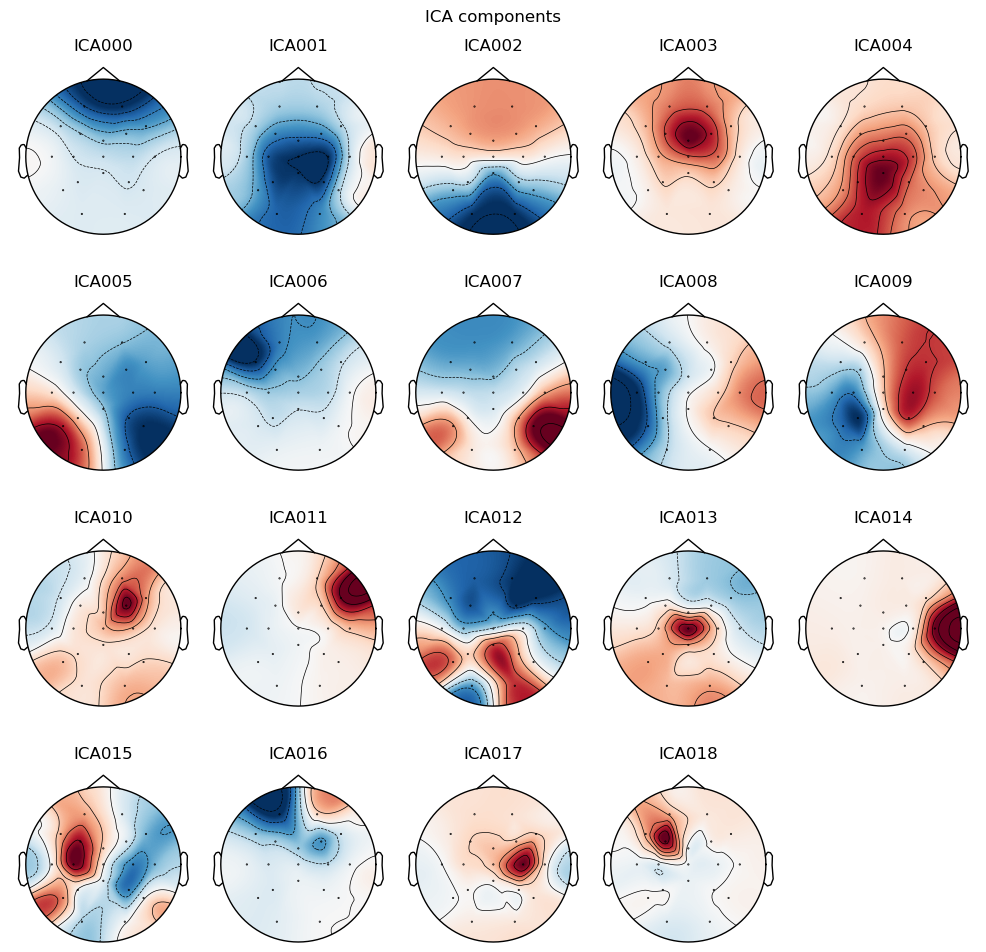

Effective window size : 8.192 (s)
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


Measurement date,"January 01, 2003 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaaaed
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [68]:
eegICA = preprocEEG.copy()
from mne.preprocessing import ICA

# Set up the ICA object, specifying the number of components to compute
ica = ICA(n_components=19, random_state=97, max_iter=1000)

# Fit ICA to the raw data
ica.fit(eegICA)

# Plot ICA components to manually inspect them
ica.plot_components()
plt.close('all')

emg_inds, scores = ica.find_bads_muscle(eegICA, threshold = 0.95)
ica.exclude.extend(emg_inds)

# Apply the ICA to the raw data
ica.apply(eegICA)

In [69]:
eegICA.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


Measurement date,"January 01, 2003 00:00:00 GMT"
Experimenter,Unknown
Participant,aaaaaaed
Digitized points,22 points
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [70]:
duration_seconds = data.shape[1] / sampfreq

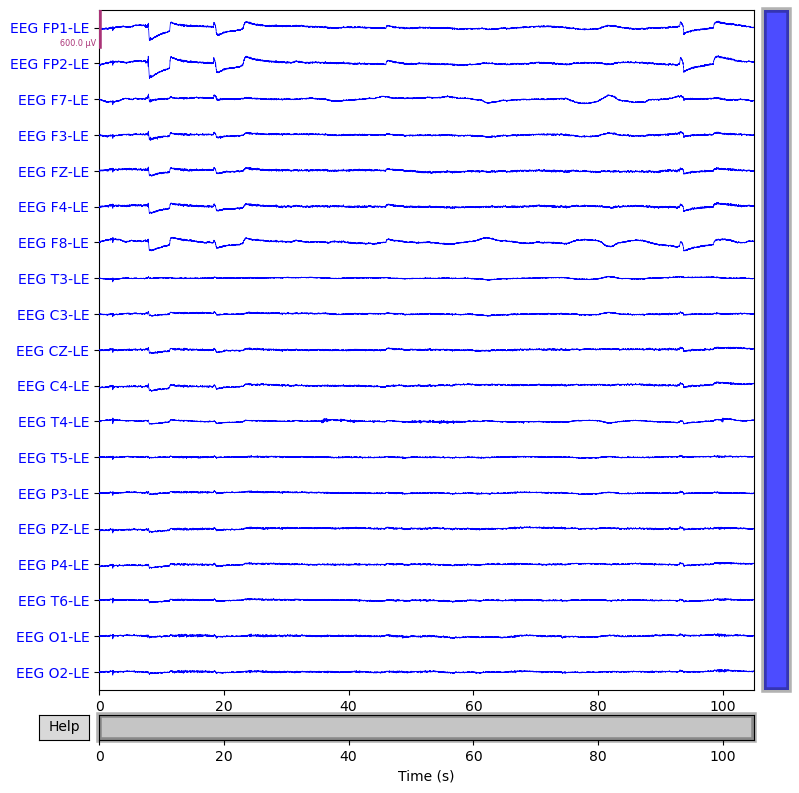

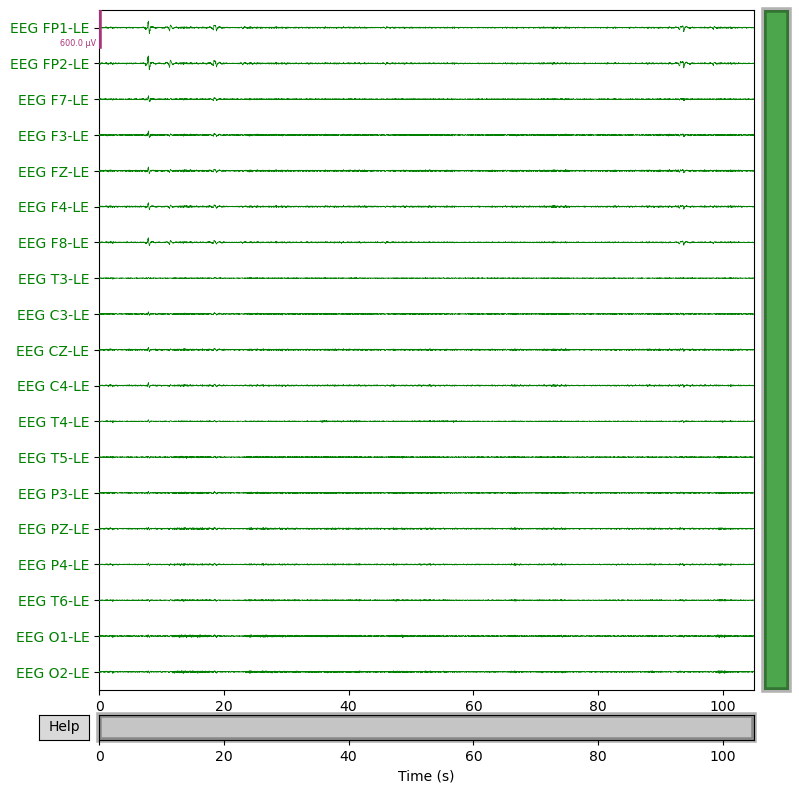

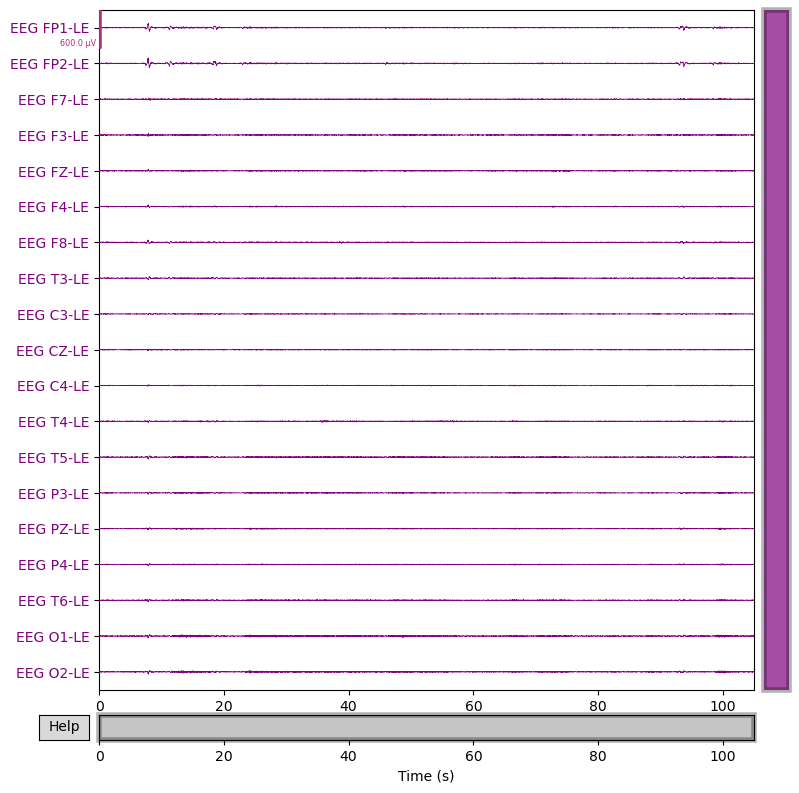

In [71]:
# Define the specific channels you want to plot
channels_to_plot = ['EEG FP1-LE']

# Close all previous figures
plt.close('all')
raw_selected.plot(
    n_channels=19,
    duration=duration_seconds,
    start=0,
    scalings= {'eeg': 3*10e-5},
    title='Raw EEG Data',
    show=True,
    block=False,
    color={'eeg': 'blue'}
)

preprocEEG.plot(
    n_channels=19,
    duration=duration_seconds,
    start=0,
    scalings= {'eeg': 3*10e-5},
    title='Raw EEG Data',
    show=True,
    block=False,
    color={'eeg': 'green'}
)

eegICA.plot(
    n_channels=19,
    duration=duration_seconds,
    start=0,
    scalings= {'eeg': 3*10e-5},
    title='Raw EEG Data',
    show=True,
    block=False,
    color={'eeg': 'purple'}
)

plt.close('all')

In [72]:
# Define the seizure and background time intervals (in seconds)

background_start_1, background_end_1 = 0, 120-15

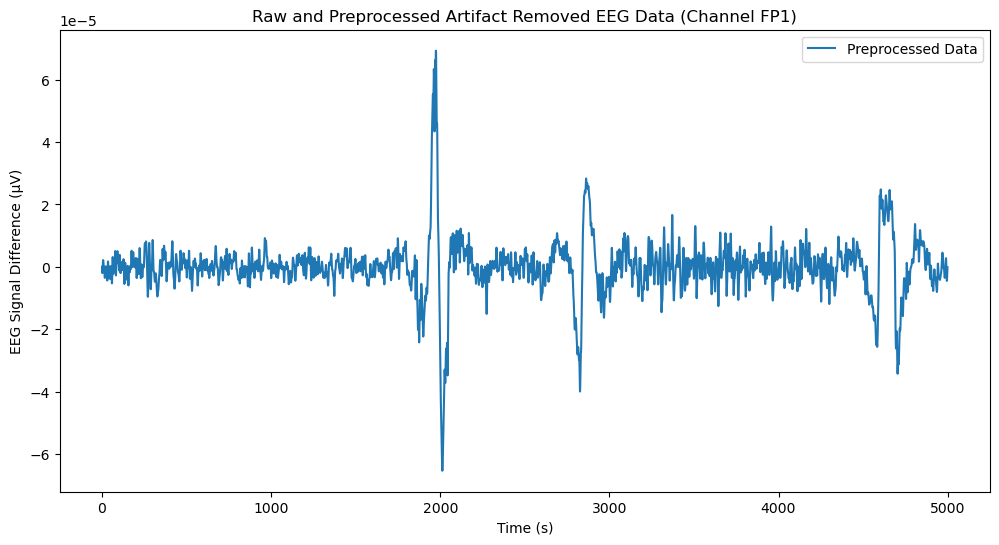

In [73]:
raw_data, raw_times = raw[:,:]
eegICA_data, eeg_times = eegICA[:,:]
# Comparison between raw and preprocessed artifact removed EEG
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
# You can keep adding more plots on the same figure this way
plt.plot(raw_times, raw_data[channel_idx, :], label='Raw Data', color='green')
plt.plot(raw_times, eegICA_data[channel_idx, :], label='Preprocessed Data')
# plt.plot(eegICA_data[channel_idx, :20*sampfreq], label='Preprocessed Data')
# plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
# plt.axvline(x=seizure_end, color='black', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (s)')
plt.ylabel('EEG Signal Difference (µV)')
plt.title(f'Raw and Preprocessed Artifact Removed EEG Data (Channel {simplified_names[channel_idx]})')
plt.legend()
plt.show()

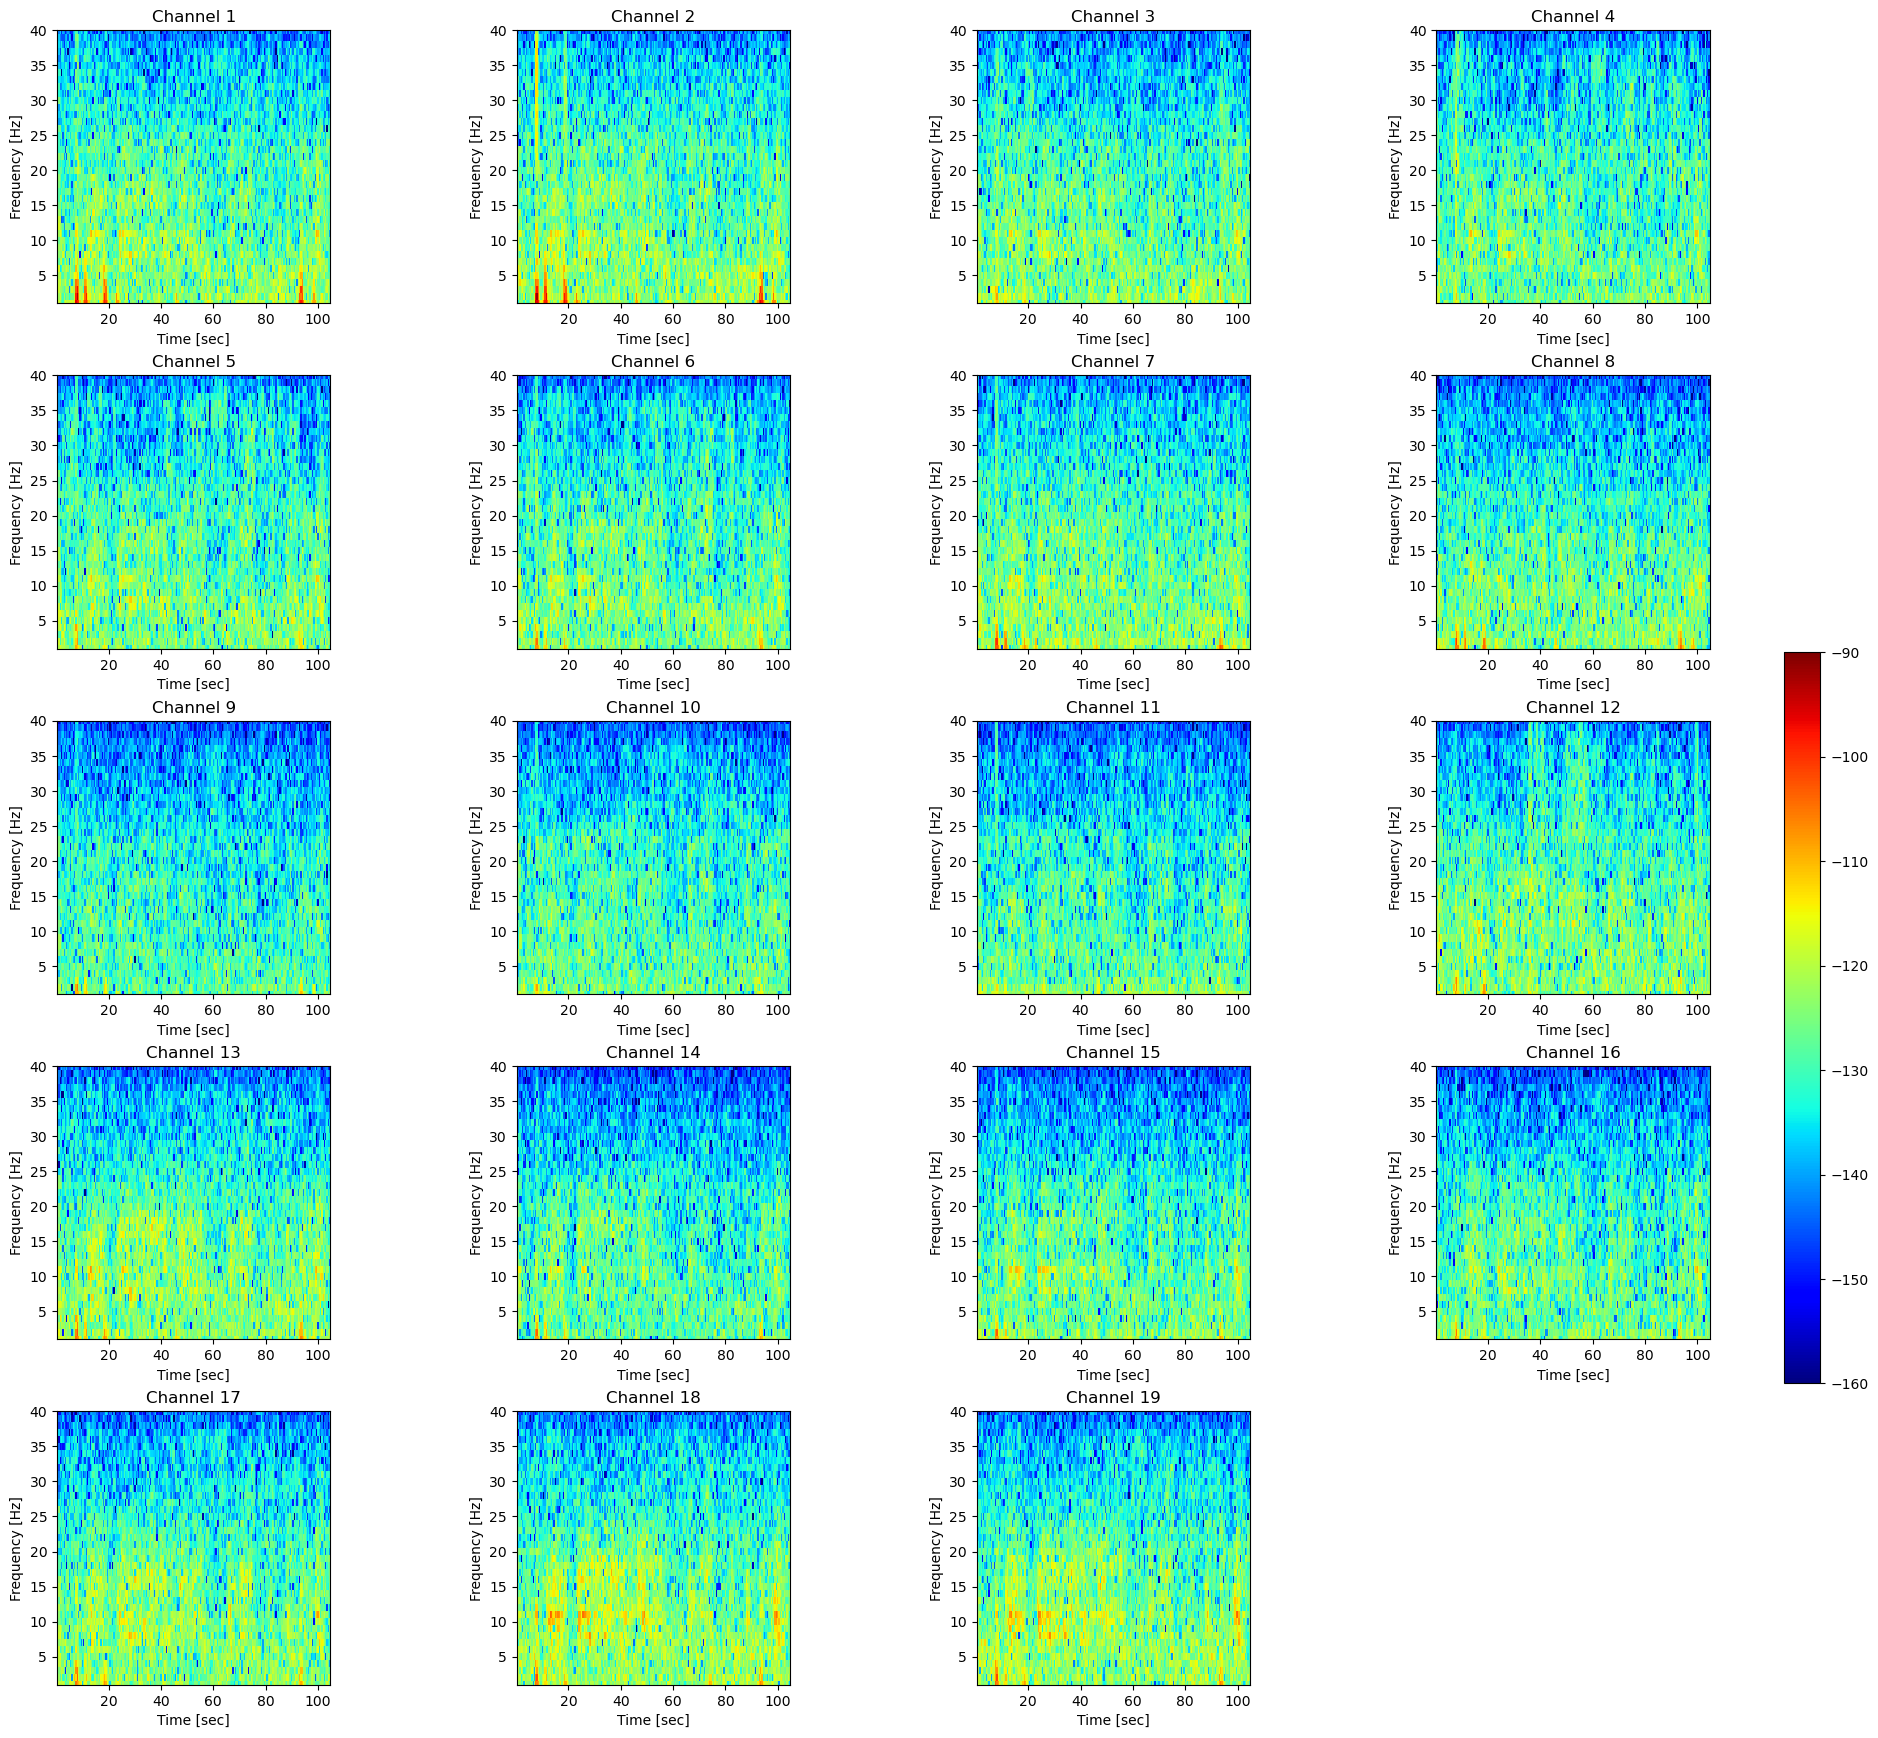

In [74]:
from scipy.signal import spectrogram

# Generate a sample signal (sine wave with two frequencies)
fs = sampfreq  # Sampling frequency (Hz)
# Extract signal data
data, times = eegICA[:, :]

# Parameters for the spectrogram
nperseg = fs  # Length of each segment (window length)
noverlap = fs//2  # Number of points to overlap between segments

nrows = 6
ncols = 4

num_channels = 19
# Create subplots for all channels
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes for easier indexing

for i in range(num_channels):
    # Generate the spectrogram for each channel
    frequencies, times, Sxx = spectrogram(data[i],  fs, nperseg=nperseg, noverlap=noverlap)
    
    # Plot spectrogram for each channel
    img = axes[i].pcolormesh(times, frequencies, 10 * np.log10(Sxx), cmap = 'jet')

    # Set color limits
    img.set_clim(-160, -90)

    axes[i].set_title(f'Channel {i+1}')
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_xlabel('Time [sec]')
    axes[i].set_ylim(1, 40)  # Adjust based on your frequency range of interest
    axes[i].set_box_aspect(1)  # equivalent of 'Box' being 'on'

# Hide unused subplots if there are fewer channels than subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()

In [75]:
def bandpass_filter(data, sfreq, low_freq, high_freq):
    """
    Band-pass filter the data.
    
    Parameters:
    data (ndarray): The input signal of shape (n_channels, n_times)
    sfreq (float): The sampling frequency
    low_freq (float): The lower bound of the frequency range
    high_freq (float): The upper bound of the frequency range
    
    Returns:
    filtered_data (ndarray): The band-pass filtered signal
    """
    nyquist = 0.5 * sfreq
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = butter(4, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data

In [76]:
def calculate_plv(phasedata):
    """
    Calculate the Phase Locking Value (PLV) between pairs of EEG channels.
    
    Parameters:
    eeg_data (ndarray): EEG data of shape (n_channels, n_times)
    sfreq (float): Sampling frequency of the EEG data
    low_freq (float): Lower frequency bound for band-pass filter (default 8 Hz)
    high_freq (float): Upper frequency bound for band-pass filter (default 13 Hz)
    
    Returns:
    plv_matrix (ndarray): PLV matrix of shape (n_channels, n_channels)
    """
    n_channels, n_times = phasedata.shape
    plv_matrix = np.zeros((n_channels, n_channels))
    
    # Calculate PLV
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            phase_diff = phasedata[i] - phasedata[j]
            plv = np.abs(np.sum(np.exp(1j * phase_diff)) / n_times)
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric
    
    return plv_matrix

In [77]:
# Helper function to create graph from PLV matrix
def create_graph(plv_matrix, ch_names):
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                G.add_edge(ch1, ch2, weight=weight)
    return G

In [78]:
# Band pass filtering and phase calculation
eeg_data, _ = eegICA[:]

# # Delta
# low_freq = 1
# high_freq = 4

# Theta
low_freq = 4
high_freq = 8

# Alpha
# low_freq = 8
# high_freq = 13

# Beta
# low_freq = 13
# high_freq = 30

# Gamma
# low_freq = 30
# high_freq = 50

# Band-pass filter the data in the specified frequency band
eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, low_freq, high_freq)
    
# Compute the analytic signal (Hilbert transform) to get the phase
analytic_signal = hilbert(eeg_data_filtered, axis=1)
phase_data = np.angle(analytic_signal)

In [79]:
eeg_data.shape

(19, 26250)

In [80]:
# Parameters
epoch_length = 1  # in seconds
epoch_samples = int(epoch_length * sampfreq)
def epoch_data(data, sfreq, epoch_length):
    n_channels, n_samples = data.shape
    epoch_samples = int(epoch_length * sfreq)
    n_epochs = n_samples // epoch_samples
    epochs = np.array_split(data[:, :n_epochs * epoch_samples], n_epochs, axis=1)
    return epochs, n_epochs

phase_epochs, n_epochs  = epoch_data(phase_data[:19, :], sampfreq, epoch_length)

plv_matrix = np.zeros((19, 19, n_epochs, high_freq-low_freq))

for freq in range(low_freq, high_freq):
    freq_n = freq-low_freq

    # Band-pass filter the data in the specified frequency band
    eeg_data_filtered = bandpass_filter(eeg_data, sampfreq, freq, freq+1)
        
    # Compute the analytic signal (Hilbert transform) to get the phase
    analytic_signal = hilbert(eeg_data_filtered, axis=1)
    phase_data = np.angle(analytic_signal)
  
    phase_epochs, _ = epoch_data(phase_data, sampfreq, epoch_length)

    epoch_n = 0
    for epoch in phase_epochs:
        plv_matrix[:, :, epoch_n, freq_n] = calculate_plv(epoch)
        epoch_n = epoch_n + 1

plv_all = np.mean(plv_matrix, axis = 3)

In [81]:
# Process epochs
ch_names = eegICA.ch_names[:]

graphs = []
epoch_n = 0
for epoch in phase_epochs:
    graph = create_graph(plv_all[:, :, epoch_n], ch_names)
    graphs.append(graph)
    epoch_n = epoch_n + 1

# Finding appropriate Threshold using Frequency Domain Bootstrap Method 

C:\Users\Atena\AppData\Local\Temp\ipykernel_11520\525917780.py:26: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hann_window = hann(L)


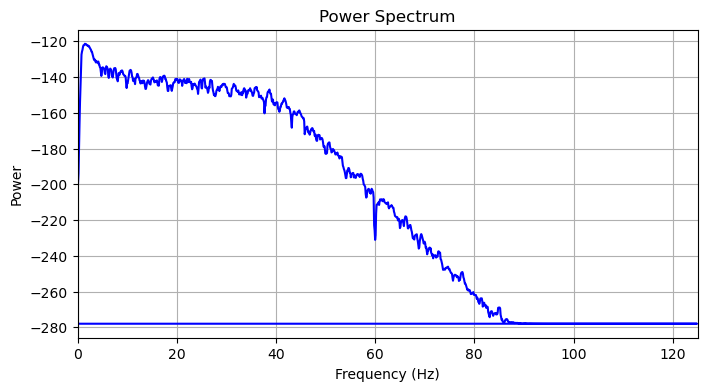

(19, 1251)


C:\Users\Atena\AppData\Local\Temp\ipykernel_11520\525917780.py:82: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  hann_window = hann(L)


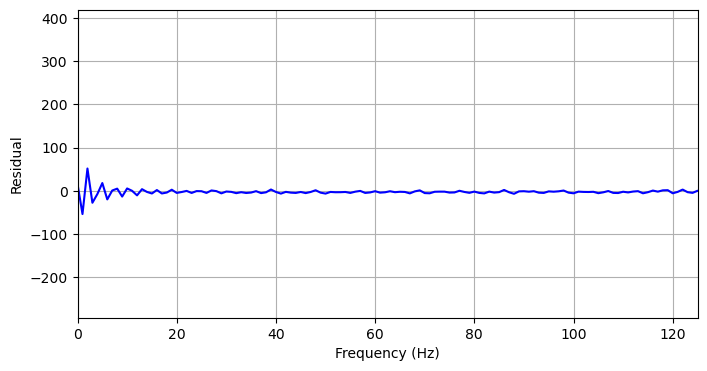

(19, 26250)
(100, 19, 2500)
(19, 19, 1000)
(361000,)


In [82]:
from scipy.fft import fft, ifft
from scipy.stats import norm
from scipy.signal import hann, periodogram
from scipy.ndimage import uniform_filter1d

def smooth_power_spectrum(power_spectrum, window_size=5):
    return uniform_filter1d(power_spectrum, size=window_size)

def compute_power_spectrum(time_series, fs):
    """
    Compute the power spectrum of the input time series using Hann window 
    and returns the one-sided power spectrum.
    
    Parameters:
    - time_series: 1D array of the signal
    - fs: Sampling frequency of the signal
    
    Returns:
    - freqs: Frequencies corresponding to the power spectrum
    - power_spectrum: One-sided power spectrum
    """
    # Length of the signal
    L = len(time_series)
    
    # Apply Hann window
    hann_window = hann(L)
    windowed_data = time_series * hann_window
    
    # Compute FFT
    fft_values = np.fft.fft(windowed_data)
    
    # Compute two-sided power spectrum
    P2 = np.abs(fft_values / L) ** 2
    
    # One-sided power spectrum (P1)
    P1 = P2[:L//2 + 1]
    P1[1:-1] = 2 * P1[1:-1]  # Double all but the first and last component
    
    # Frequencies corresponding to the power spectrum
    freqs = np.fft.fftfreq(L, 1/fs)[:L//2 + 1]
    
    power_spectrum = P1
    spower_spectrum = smooth_power_spectrum(power_spectrum, window_size=5)
    return freqs, spower_spectrum

# Compute power spectrum
freqs, spower_spectrum = compute_power_spectrum(eeg_data[0, :10*sampfreq], sampfreq)

# Plot the power spectrum
plt.figure(figsize=(8, 4))
plt.plot(freqs, 10*np.log10(spower_spectrum), color='blue')
plt.title('Power Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.grid(True)
plt.xlim([0, fs/2])  # Only plot the positive frequencies (up to Nyquist)
plt.show()

# Step 1: Compute power spectrum for each time series and average them
# time_series is an array of shape (19, x)
power_spectra = np.array([compute_power_spectrum(eeg_data[i, :10*sampfreq], sampfreq)[1] for i in range(eeg_data.shape[0])])

print(power_spectra.shape)

avg_spectrum = np.mean(power_spectra, axis=0)

def compute_whitened_residuals(time_series, avg_spectrum):
    """
    Compute the whitened residuals of the time series using the one-sided average power spectrum.
    
    Parameters:
    - time_series: The input signal (1D array)
    - avg_spectrum: The one-sided average power spectrum (should have length L//2 + 1, where L is the length of the time series)
    
    Returns:
    - residuals: The whitened residuals (1D array, same length as time_series)
    """
    # Length of the signal
    L = len(time_series)

    # Apply Hann window
    hann_window = hann(L)
    windowed_data = time_series * hann_window
    
    # Compute FFT
    fft_values = np.fft.fft(windowed_data)
        
    spectrum = fft_values
    
    # Create a two-sided spectrum from the one-sided avg_spectrum
    avg_spectrum_full = np.zeros(L)
    avg_spectrum_full[:L//2 + 1] = avg_spectrum
    avg_spectrum_full[L//2+1:] = np.flip(avg_spectrum[1:-1])
    
    # Avoid division by zero by adding a small constant if needed
    eps = 1e-10  # Small constant to prevent division by zero
    avg_spectrum_full = np.where(avg_spectrum_full == 0, eps, avg_spectrum_full)
    
    # Compute the whitened spectrum (divide by sqrt of avg_spectrum_full)
    whitened_spectrum = spectrum / np.sqrt(abs(avg_spectrum_full))
    
    # Compute the residuals by applying the inverse FFT
    residuals = ifft(whitened_spectrum)
    
    # Return the real part of the residuals (since the result might have very small imaginary values)
    return np.real(residuals)

# Step 2: Compute the whitened residuals for each time series
whitened_residuals = np.array([compute_whitened_residuals(eeg_data[i, :10*sampfreq], avg_spectrum) for i in range(eeg_data.shape[0])])

# Plot the power spectrum
plt.figure(figsize=(8, 4))
plt.plot(whitened_residuals[0], color='blue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Residual')
plt.grid(True)
plt.xlim([0, fs/2])  # Only plot the positive frequencies (up to Nyquist)
plt.show()

def resample_with_replacement(data):
    """Resample data with replacement."""
    indices = np.random.randint(0, data.shape, data.shape)
    return data[indices]

n_nodes = 19
n_data_points = eeg_data[:, :10*sampfreq].shape[1]
n_surrogates = 100
surrogate_data = np.zeros((n_surrogates, n_nodes, n_data_points), dtype=complex)
    
for i in range(n_surrogates):
    for node in range(n_nodes):
        # Resample residuals and compute surrogate data
        resampled_residuals = resample_with_replacement(whitened_residuals[node])
        # Length of the signal
        L = whitened_residuals.shape[1]
        # Create a two-sided spectrum from the one-sided avg_spectrum
        avg_spectrum_full = np.zeros(L)
        avg_spectrum_full[:L//2 + 1] = avg_spectrum
        avg_spectrum_full[L//2+1:] = np.flip(avg_spectrum[1:-1])
        surrogate_spectrum = fft(resampled_residuals) * np.sqrt(abs(avg_spectrum_full)) 
        surrogate_data[i, node] = ifft(surrogate_spectrum)

surrogate_datar = np.real(surrogate_data) 

print(eeg_data.shape)
print(surrogate_data.shape)

n_surrog = 100
n_surrogate_epochs = 10
plv_matrix_surrogate = np.zeros((19, 19, n_surrogate_epochs, high_freq-low_freq, n_surrog))

for surrog_num in range(n_surrog):
    for freq in range(low_freq, high_freq):
        freq_n = freq-low_freq

        # Band-pass filter the data in the specified frequency band
        eeg_data_filtered = bandpass_filter(surrogate_datar[surrog_num, :, :], sampfreq, freq, freq+1)
            
        # Compute the analytic signal (Hilbert transform) to get the phase
        analytic_signal = hilbert(eeg_data_filtered, axis=1)
        phase_data = np.angle(analytic_signal)

        phase_Seg = phase_data.copy()

        surrogate_phase_epochs, _ = epoch_data(phase_Seg, sampfreq, epoch_length)

        epoch_n = 0
        for epoch in surrogate_phase_epochs:
            plv_matrix_surrogate[:, :, epoch_n, freq_n, surrog_num] = calculate_plv(epoch)
            epoch_n = epoch_n + 1

plv_surrogate_all = np.mean(plv_matrix_surrogate, axis = 3)

surrogate_plv = plv_surrogate_all.reshape(19, 19, -1)
print(surrogate_plv.shape)
surrogate_distribution = surrogate_plv.flatten()
print(surrogate_distribution.shape)
np.save('surrogate_distribution_aed.npy', surrogate_distribution)

0.1471837488457987


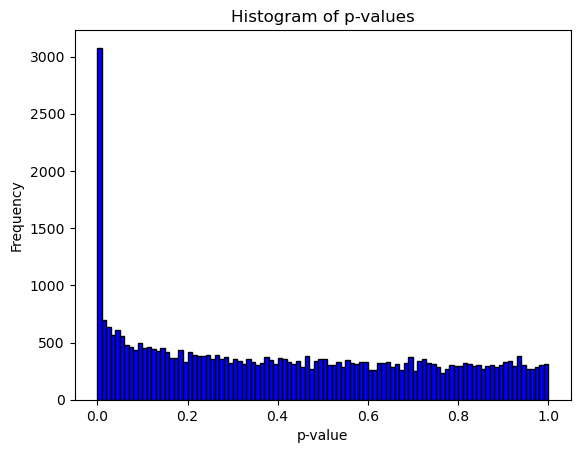

In [85]:
n_nodes = 19
p_values = np.zeros((n_nodes, n_nodes, n_epochs))
for i in range(n_nodes):
    for j in range(i+1, n_nodes):
        for epoch in range(n_epochs):
            original_value = plv_all[i, j, epoch]
            p_values[i, j, epoch] = np.mean(surrogate_distribution >= original_value)
            p_values[j, i, epoch] = p_values[i, j, epoch]  # Since it's symmetric

plv_bi= (p_values<0.05).astype(int)

ratio_edge = np.sum(plv_bi)/plv_bi.size
print(ratio_edge)

# Create a histogram
plt.hist(p_values.flatten(), bins=100, color='blue', edgecolor='black')
# Add title and labels
plt.title('Histogram of p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
# Show the plot
plt.show()

In [86]:
# Helper function to create graph from PLV matrix
def create_graph_bi(plv_matrix, ch_names):
    
    G = nx.Graph()
    for i, ch1 in enumerate(ch_names):
        for j, ch2 in enumerate(ch_names):
            if i < j:  # To avoid duplicate edges
                weight = plv_matrix[i, j]
                if weight == 1:
                    G.add_edge(ch1, ch2, weight=1)  # Binary edge
    return G

In [87]:
graphs_bi = []
epoch_n = 0
for epoch in phase_epochs:
    graph = create_graph_bi(plv_bi[:, :, epoch_n], ch_names)
    graphs_bi.append(graph)
    epoch_n = epoch_n + 1

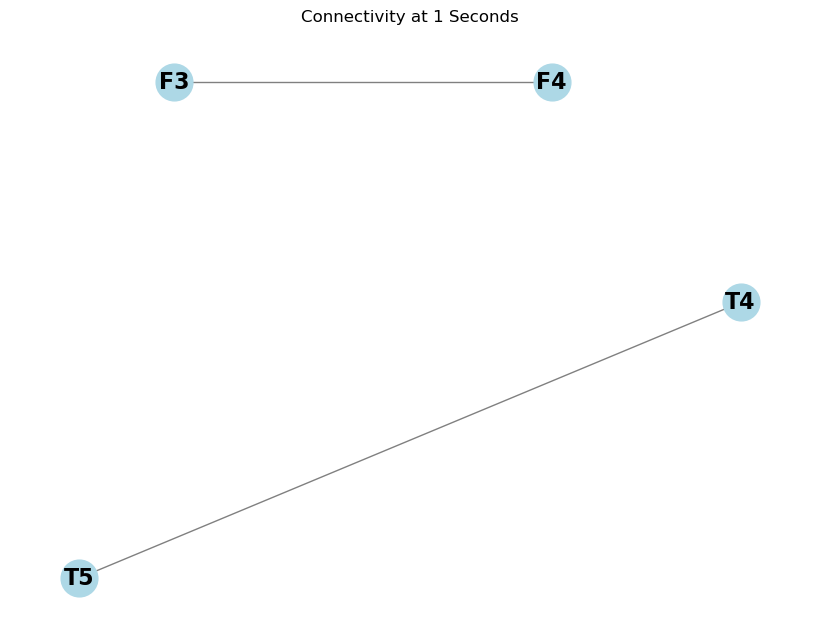

In [88]:
pos = {'FP1': (-0.3, 0.8),
 'FP2': (0.3, 0.8),
 'F3': (-0.4, 0.4),
 'F4': (0.4, 0.4),
 'C3': (-0.5, 0.0),
 'C4': (0.5, 0.0),
 'P3': (-0.4, -0.4),
 'P4': (0.4, -0.4),
 'O1': (-0.3, -0.8),
 'O2': (0.3, -0.8),
 'F7': (-0.7, 0.5),
 'F8': (0.7, 0.5),
 'T3': (-0.8, 0),
 'T4': (0.8, 0),
 'T5': (-0.6, -0.5),
 'T6': (0.6, -0.5),
 'FZ': (0.0, 0.3),
 'CZ': (0.0, 0.0),
 'PZ': (0.0, -0.3)}

# Create the mapping dictionary
label_mapping = dict(zip(selected_channels, simplified_names))

# Function to relabel nodes
def relabel_nodes(G, mapping):
    return nx.relabel_nodes(G, mapping, copy=True)

# Plot graphs
for i in range(0, 40, 40): 
    G = graphs_bi[i]
    # Relabel the nodes in the graph
    G = relabel_nodes(G, label_mapping)
    weights = nx.get_edge_attributes(G, 'weight')
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=16, font_weight='bold', edge_color='gray')
    plt.title(f'Connectivity at {i+1} Seconds')
    plt.show()


[{'density': 0.3333333333333333}, {'density': 0.2087912087912088}, {'density': 0.2087912087912088}, {'density': 0.5}, {'density': 0.2222222222222222}, {'density': 0.2727272727272727}, {'density': 0.4}, {'density': 0.26666666666666666}, {'density': 0.25}, {'density': 0.32727272727272727}, {'density': 0.28205128205128205}, {'density': 0.34065934065934067}, {'density': 0.21428571428571427}, {'density': 0.43956043956043955}, {'density': 0.21212121212121213}, {'density': 0.6285714285714286}, {'density': 0.17777777777777778}, {'density': 0.14285714285714285}, {'density': 0.2545454545454545}, {'density': 0.38095238095238093}, {'density': 0.1111111111111111}, {'density': 0.25}, {'density': 0.32727272727272727}, {'density': 0.2857142857142857}, {'density': 0.35}, {'density': 0.6190476190476191}, {'density': 0.4}, {'density': 0.23076923076923078}, {'density': 0.13636363636363635}, {'density': 0.2857142857142857}, {'density': 0.19696969696969696}, {'density': 0.19047619047619047}, {'density': 0.3

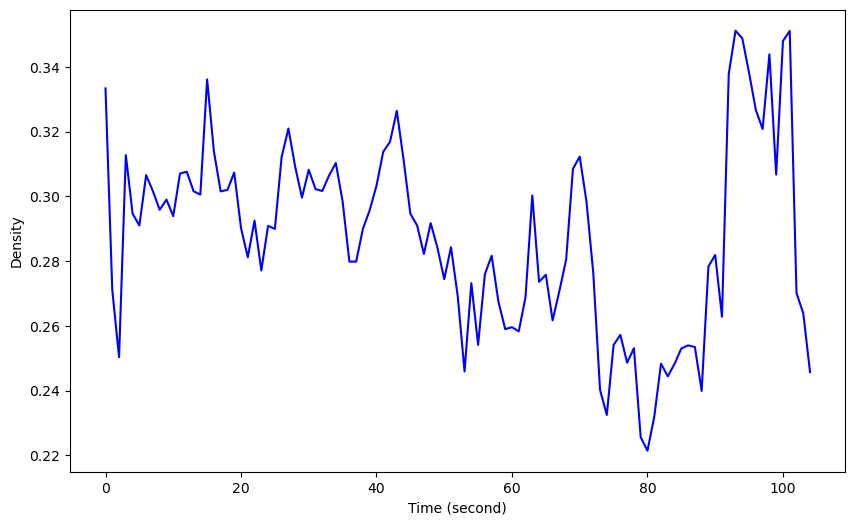

In [89]:
def feature_extract_bi(graph):
    features = {}
    
    features['density'] = nx.density(graph)
        
    return features

features_bi = [feature_extract_bi(G) for G in graphs_bi]
print(features_bi)

# Initialize lists to collect each feature
density_list = []

# Collect each feature into lists
for features in features_bi:
    density_list.append(features['density'])

# Convert lists to numpy arrays for easier computation
density_array = np.array(density_list)

# Convert the arrays to pandas Series and compute the moving average
density_moving_avg = pd.Series(density_array).rolling(window=10, min_periods=1).mean().to_numpy()

plt.close('all')
length = len(density_moving_avg)
x_values = list(range(0, length*1, 1))
plt.figure(figsize=(10, 6))
plt.plot(x_values, density_moving_avg, color='blue')
# plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
# plt.axvline(x=seizure_end, color='black', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (second)')
plt.ylabel('Density')
plt.show()

In [29]:
def feature_extract(graph):
    features = {}

    # Calculate graph density
    features['density'] = nx.density(graph)

    # Average Clustering Coefficient
    if graph.number_of_edges() > 0:
      features['avg_clustering'] = nx.average_clustering(graph)
    else:
      features['avg_clustering'] = 0 

    # Modularity requires community detection, using the 'community' package from 'python-louvain'
    # You may need to install it using: pip install python-louvain
    from community import community_louvain
    # Find communities using the Louvain method
    if graph.number_of_edges() > 0:
        partition = community_louvain.best_partition(graph)
        features['modularity'] = community_louvain.modularity(partition, graph)
    else:
        partition = {}  # An empty partition, or you can set this to another default value if necessary
        features['modularity'] = 0  # Or set to None, or any other default value

    # Assortativity (Degree Assortativity Coefficient)
    features['assortativity'] = nx.degree_assortativity_coefficient(graph)
    
    return features

def feature_extract_w(graph):
    features_w = {}

    # features_w['characteristic_path_length'] = nx.average_shortest_path_length(graph, weight='weight')
        # Create a new graph with inverted weights
    inverted_graph = nx.Graph()
    for u, v, d in graph.edges(data=True):
        if d['weight'] != 0:  # Ensure the weight is non-zero to avoid division by zero
            inverted_graph.add_edge(u, v, weight=1.0 / d['weight'])

    # Calculate the characteristic path length using the inverted weights
    features_w['characteristic_path_length'] = nx.average_shortest_path_length(inverted_graph, weight='weight')
    
    return features_w

features_ = [feature_extract(G) for G in graphs_bi]
print(features_)

features_w = [feature_extract_w(G) for G in graphs]
print(features_w)

# Initialize lists to collect each feature
density_list = []
clustcoef_list = []
modularity_list = []
assort_list = []
path_list = []

# Collect each feature into lists
for features in features_:
    density_list.append(features['density'])
    clustcoef_list.append(features['avg_clustering'])
    modularity_list.append(features['modularity'])
    assort_list.append(features['assortativity'])
for features in features_w:
    path_list.append(features['characteristic_path_length'])

# Convert lists to numpy arrays for easier computation
density_array = np.array(density_list)
# density_seizure_array = density_array.copy()[seizure_start:seizure_end]
density_background_array = density_array.copy()[background_start_1:background_end_1]
# # Calculate mean and standard deviation for each feature
# mean_density_seizure = np.mean(density_seizure_array)
# std_density_seizure = np.std(density_seizure_array)
# Print results
# print(f"Density Seizure: Mean = {mean_density_seizure}, Standard Deviation = {std_density_seizure}")
# Calculate mean and standard deviation for each feature
mean_density_background = np.mean(density_background_array)
std_density_background = np.std(density_background_array)
# Print results
print(f"Density Background: Mean = {mean_density_background}, Standard Deviation = {std_density_background}")

# Convert lists to numpy arrays for easier computation - Clustcoef
clustcoef_array = np.array(clustcoef_list)
# clustcoef_seizure_array = clustcoef_array.copy()[seizure_start:seizure_end]
clustcoef_background_array = clustcoef_array.copy()[background_start_1:background_end_1]
# # Calculate mean and standard deviation for each feature
# mean_clustcoef_seizure = np.mean(clustcoef_seizure_array)
# std_clustcoef_seizure = np.std(clustcoef_seizure_array)
# Print results
# print(f"Clustcoef Seizure: Mean = {mean_clustcoef_seizure}, Standard Deviation = {std_clustcoef_seizure}")
mean_clustcoef_background = np.mean(clustcoef_background_array)
std_clustcoef_background = np.std(clustcoef_background_array)
print(f"Clustcoef Background: Mean = {mean_clustcoef_background}, Standard Deviation = {std_clustcoef_background}")

# Convert lists to numpy arrays for easier computation - Modularity
modularity_array = np.array(modularity_list)
# modularity_seizure_array = modularity_array.copy()[seizure_start:seizure_end]
modularity_background_array = modularity_array.copy()[background_start_1:background_end_1]
# mean_modularity_seizure = np.mean(modularity_seizure_array)
# std_modularity_seizure = np.std(modularity_seizure_array)
# print(f"Modularity Seizure: Mean = {mean_modularity_seizure}, Standard Deviation = {std_modularity_seizure}")
mean_modularity_background = np.mean(modularity_background_array)
std_modularity_background = np.std(modularity_background_array)
print(f"Modularity Background: Mean = {mean_modularity_background}, Standard Deviation = {std_modularity_background}")

# Convert lists to numpy arrays for easier computation - Path Length
path_array = np.array(path_list)
# path_seizure_array = path_array.copy()[seizure_start:seizure_end]
path_background_array = path_array.copy()[background_start_1:background_end_1]
# mean_path_seizure = np.mean(path_seizure_array)
# std_path_seizure = np.std(path_seizure_array)
# print(f"Path Length Seizure: Mean = {mean_path_seizure}, Standard Deviation = {std_path_seizure}")
mean_path_background = np.mean(path_background_array)
std_path_background = np.std(path_background_array)
print(f"Path Length Background: Mean = {mean_path_background}, Standard Deviation = {std_path_background}")

c:\Users\Atena\anaconda3\envs\eegnetmibci\lib\site-packages\networkx\algorithms\assortativity\correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return float((xy * (M - ab)).sum() / np.sqrt(vara * varb))


[{'density': 0.5555555555555556, 'avg_clustering': 0.7005291005291006, 'modularity': 0.15499999999999997, 'assortativity': 0.10326086956521645}, {'density': 0.1388888888888889, 'avg_clustering': 0.0, 'modularity': 0.7200000000000001, 'assortativity': -0.2500000000000021}, {'density': 0.24175824175824176, 'avg_clustering': 0.719047619047619, 'modularity': 0.5175619834710743, 'assortativity': 0.2452350698856414}, {'density': 0.43636363636363634, 'avg_clustering': 0.6476190476190476, 'modularity': 0.16319444444444442, 'assortativity': 0.17616580310880967}, {'density': 0.2878787878787879, 'avg_clustering': 0.4083333333333334, 'modularity': 0.2617728531855956, 'assortativity': 0.5228310502283112}, {'density': 0.5494505494505495, 'avg_clustering': 0.7364770150484435, 'modularity': 0.11519999999999993, 'assortativity': -0.07649442755825829}, {'density': 0.18181818181818182, 'avg_clustering': 0.5757575757575757, 'modularity': 0.64, 'assortativity': 0.5918367346938781}, {'density': 0.1212121212

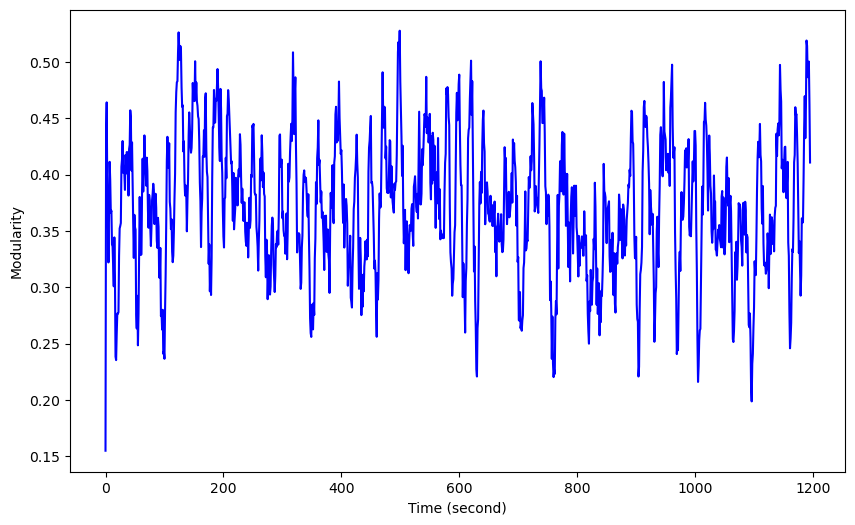

In [30]:
# Convert the arrays to pandas Series and compute the moving average
modularity_moving_avg = pd.Series(modularity_array).rolling(window=10, min_periods=1).mean().to_numpy()

plt.close('all')
length = len(modularity_moving_avg)
x_values = list(range(0, length*1, 1))
plt.figure(figsize=(10, 6))
plt.plot(x_values, modularity_moving_avg, color='blue')
plt.xlabel('Time (second)')
plt.ylabel('Modularity')
plt.show()